In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


# Vision Datasets & Data Augmentation

In [7]:
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms import ToTensor, RandomCrop, CenterCrop, Resize, Compose

In [8]:
train_t = Compose([
             Resize(32),
             RandomCrop(28),
             ToTensor()
])

test_t = Compose([
             Resize(32),
             CenterCrop(28),
             ToTensor()
])

print(train_t)

Compose(
    Resize(size=32, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(28, 28), padding=None)
    ToTensor()
)


In [9]:
mnist_train = MNIST(root='./mnist', train=True, transform=train_t, target_transform=None, download=True)
mnist_test = MNIST(root='./mnist', train=False, transform=test_t, target_transform=None, download=True)

print(mnist_train.data.shape, mnist_train.targets.shape, mnist_train.data[0].shape)
print(mnist_test.data.shape, mnist_test.targets.shape, mnist_test.data[0].shape)

0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...


/home/fabiovalerio/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([28, 28])
torch.Size([10000, 28, 28]) torch.Size([10000]) torch.Size([28, 28])


In [10]:
cifar10_train = CIFAR10(root='./cifar10', train=True, transform=train_t, target_transform=None, download=True)
cifar10_test = CIFAR10(root='./cifar10', train=False, transform=test_t, target_transform=None, download=True)

print(cifar10_train.data.shape, len(cifar10_train.targets), cifar10_test.data[0].shape)
print(cifar10_test.data.shape, len(cifar10_test.targets), cifar10_test.data[0].shape)

0it [00:00, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
(50000, 32, 32, 3) 50000 (32, 32, 3)
(10000, 32, 32, 3) 10000 (32, 32, 3)


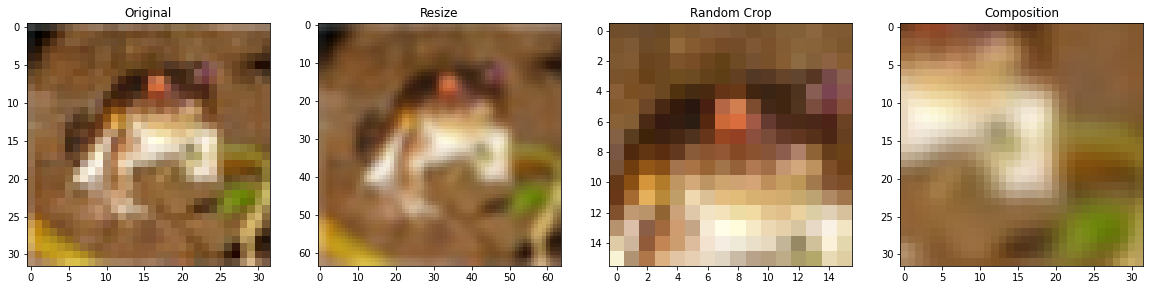

In [11]:
img = cifar10_train.data[0]
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(img)
plt.subplot(1, 4, 2)
t = Resize(64)
plt.title("Resize")
plt.imshow(t(Image.fromarray(img)))
plt.subplot(1, 4, 3)
t = RandomCrop(16)
plt.title("Random Crop")
plt.imshow(t(Image.fromarray(img)))
plt.subplot(1, 4, 4)
t = Compose([Resize(64), RandomCrop(32)])
plt.title("Composition")
plt.imshow(t(Image.fromarray(img)))
plt.show();

# Create Validation split

In [12]:
mnist_valid = MNIST(root='./mnist', train=True, transform=test_t)

num_train = len(mnist_train)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

# Shuffle
np.random.seed(1331)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
loader_train = DataLoader(dataset=mnist_train, batch_size=512, sampler=train_sampler)
loader_valid = DataLoader(dataset=mnist_valid, batch_size=512, sampler=valid_sampler)
loader_test = DataLoader(dataset=mnist_test, batch_size=512, shuffle=False)

# Build the Deep Convolutional Neural Network

In [14]:
class MyModelConv(nn.Module):
    def __init__(self):
        super(MyModelConv, self).__init__()

        self.relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=True)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, bias=True)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, bias=True)

        self.linear1 = nn.Linear(in_features=32*18*18, out_features=128, bias=True)
        self.linear2 = nn.Linear(in_features=128, out_features=10, bias=True)


    def forward(self, x, avg_pool=False):
        o1 = self.relu(self.conv1(x))
        o2 = self.relu(self.conv2(o1))
        o3 = self.relu(self.conv3(o2))
        o4 = self.relu(self.avg_pool(o3)) if avg_pool else self.relu(self.linear1(o3.view(o3.shape[0], -1)))
        return self.linear2(o4.squeeze())

In [15]:
model = MyModelConv()
model.to(device)

MyModelConv(
  (relu): ReLU()
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=10368, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

# Train the model

In [16]:
sgd = SGD(params=model.parameters(), lr=1.e-3, momentum=0.9, weight_decay=1.e-4, nesterov=True)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 1

for epoch in range(epochs):

    model.train()
    loss = 0
    correct = 0
    total = 0
    sgd.zero_grad()
    for idx, data in enumerate(tqdm(loader_train, total=len(loader_train), leave=False)):
        x, y = data
        total += x.shape[0]
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss_ = criterion(pred, y) 

        loss_.backward()
        sgd.step()
        sgd.zero_grad()

        loss += loss_.item()
        correct += pred.max(-1)[1].eq(y).sum().item()

    print(f"\nTRAIN at epoch [{epoch}]/[{epochs}]")
    print(f"Loss: {loss/len(loader_train):.4f} -- Accuracy: {correct / total * 100:.2f}%") 

  
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, data in enumerate(tqdm(loader_valid, total=len(loader_valid), leave=False)):
            x, y = data
            total += x.shape[0]
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss_ = criterion(pred, y) 

            loss += loss_.item()
            correct += pred.max(-1)[1].eq(y).sum().item()

    print(f"\nValidation at epoch [{epoch}]/[{epochs}]")
    print(f"Loss: {loss/len(loader_valid):.4f} -- Accuracy: {correct / total * 100:.2f}%\n") 







  0%|          | 0/106 [00:00<?, ?it/s]




  1%|          | 1/106 [00:00<00:18,  5.71it/s]




  2%|▏         | 2/106 [00:00<00:13,  7.49it/s]




  3%|▎         | 3/106 [00:00<00:12,  8.44it/s]




  4%|▍         | 4/106 [00:00<00:11,  8.97it/s]




  5%|▍         | 5/106 [00:00<00:10,  9.22it/s]




  6%|▌         | 6/106 [00:00<00:10,  9.41it/s]




  7%|▋         | 7/106 [00:00<00:10,  9.39it/s]




  8%|▊         | 8/106 [00:00<00:10,  9.27it/s]




  8%|▊         | 9/106 [00:01<00:10,  9.28it/s]




  9%|▉         | 10/106 [00:01<00:10,  9.35it/s]




 10%|█         | 11/106 [00:01<00:10,  9.14it/s]




 11%|█▏        | 12/106 [00:01<00:10,  9.20it/s]




 12%|█▏        | 13/106 [00:01<00:10,  9.17it/s]




 13%|█▎        | 14/106 [00:01<00:09,  9.25it/s]




 14%|█▍        | 15/106 [00:01<00:09,  9.19it/s]




 15%|█▌        | 16/106 [00:01<00:09,  9.23it/s]




 16%|█▌        | 17/106 [00:01<00:09,  9.33it/s]




 17%|█▋        | 18/106 [00:01<00:09,  9.23it/s]




 18%|█


TRAIN at epoch [0]/[1]
Loss: 2.3012 -- Accuracy: 9.95%







 33%|███▎      | 4/12 [00:00<00:00, 13.69it/s]




 50%|█████     | 6/12 [00:00<00:00, 14.23it/s]




 67%|██████▋   | 8/12 [00:00<00:00, 14.69it/s]




 83%|████████▎ | 10/12 [00:00<00:00, 14.77it/s]




100%|██████████| 12/12 [00:00<00:00, 15.41it/s]




                                               


Validation at epoch [0]/[1]
Loss: 2.2971 -- Accuracy: 9.27%



# Test the trained model

In [18]:
model.eval()
loss = 0
correct = 0
total = 0
with torch.no_grad():
    for idx, data in enumerate(tqdm(loader_test, total=len(loader_test), leave=False)):
        x, y = data
        total += x.shape[0]
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss_ = criterion(pred, y) 

        loss += loss_.item()
        correct += pred.max(-1)[1].eq(y).sum().item()

print(f"TEST performance")
print(f"Loss: {loss/len(loader_test):.4f} -- Accuracy: {correct / total * 100:.2f}%\n") 

TEST performance
Loss: 0.4355 -- Accuracy: 87.83%



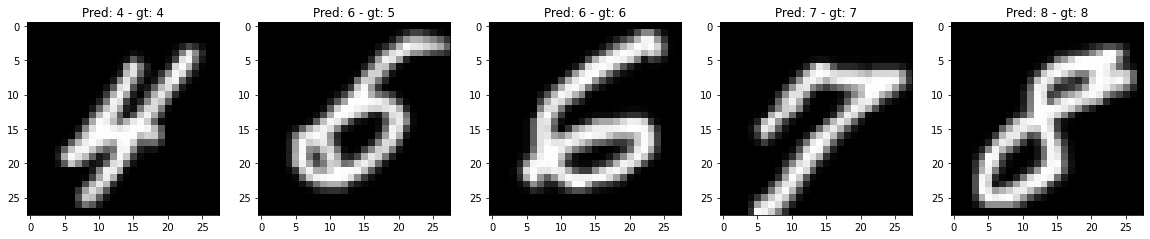

In [19]:
model.eval()
plt.figure(figsize=(20, 10))
for idx, (img, label) in enumerate(zip(x[:5], y[:5])):
    plt.subplot(1, 5, idx+1)
    plt.title(f"Pred: {pred.max(-1)[1][idx]} - gt: {label}")
    plt.imshow(img.detach().cpu().squeeze().numpy(), cmap='gray')
plt.show();